# HWRS640 - Assignment 1: Computer architecture and parallel computing

## Due date: Friday, February 6th at 11:59 PM
## Nathan Strom

In [ ]:
import numpy as np
import pandas as pd 
import matplotlib.pyplot as plt
import sklearn as skl 
import time 
import xarray as xr
import dask 
import dask.array as da

## Problem 1: Supercomputer architecture (25 points)

The top 500 supercomputers in the world are ranked based on their performance on the LINPACK benchmark, which measures a system's floating-point computing power. Visit the [Top500 website](https://www.top500.org/lists/top500/) and select one of the top 50 supercomputers. Write a short report (~0.5-1 page) that includes the following information:

1. The name and location of the supercomputer.
2. The architecture of the supercomputer (e.g., CPU type, number of cores, memory, interconnect).
3. The peak performance of the supercomputer in FLOPS (floating-point operations per second).
4. A brief discussion of the applications or research areas that benefit from this supercomputer's capabilities.


### Aurora Supercomputer

The Aurora supercomputer is housed in the Argonne National Laboratory in Lemont, Illinois. The computer's CPU is an Intel Xeon Max 9470, with 52 cores. Each core can run at 2.4 GHz (~2.4 billion cycles per second). Memory is a unified memory architecture, meaning multiple processors can access the same memory space. There are 10,624 nodes, each with 2 CPUs, for a total of 52 cores per CPU. The computer contains 10 petabytes of memory and 230 petabytes of storage. 

The peak performance for the “LINPAC Performance,” a benchmark which tests computing speed for solving a system of linear equations, is 1,012 PFlop/s, or 1.012e+18 Flop/s in real tested performance, with a theoretical limit of 1,980.01 PFlop/s. The High-Performance Conjugate Gradients (HPCG) benchmark, which tests the solution speed for problems similar to common HPC applications, achieves 5,612.6 TFlop/s (5.6126e+15 Flop/s).

The Aurora computer is currently used for scientific research applications. These applications include neuroscience, nuclear and nanophysics, cosmology, and medical research, particularly cancer research.  

Webpages used for information: https://www.hpcg-benchmark.org/, https://en.wikipedia.org/wiki/LINPACK_benchmarks, https://en.wikipedia.org/wiki/Aurora_(supercomputer), https://www.top500.org/system/180183/


## Problem 2: Moore's Law and Linear Regression (25 points)


Moore's Law states that the number of transistors on a microchip doubles approximately every two years, leading to an exponential increase in computing power. Using the provided historical data, given in `computational_methods_course/data/moores.csv`, perform the following tasks:

1. Load the data into a pandas DataFrame.
2. Use linear regression to model the relationship between the year and the number of transistors.
3. Plot the original data points and the fitted regression line.
4. Compute the doubling time of transistors based on your regression model, and compare it to the commonly cited value of two years.
5. (for fun). Compute the same regression for the first 10 years of the data and the last 10 years of the data. Has the doubling time changed over the history of computing?

In [ ]:
# 1. Load the data into a pandas DataFrame.
fp = "/workspaces/computational_methods_course_nstrom/data/moores.csv"
df_m = pd.read_csv(fp,header=1)
print(df_m.columns)

Index(['Name', 'Transistor Count', 'Year', 'Manufacturer', 'Process', 'Area',
       'Source File'],
      dtype='str')


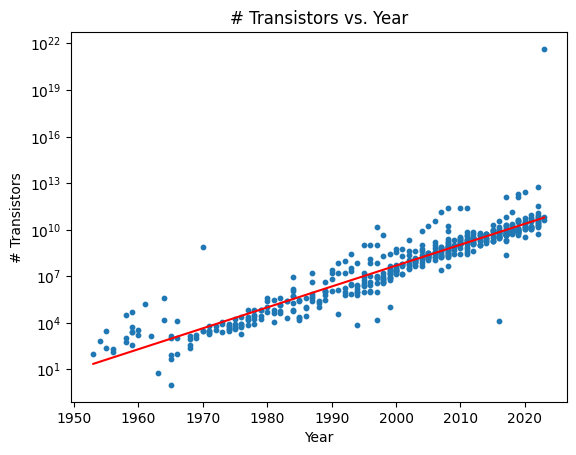

In [41]:
# 2. Use linear regression to model the relationship between the year and the number of transistors.

x = pd.to_numeric(df_m['Year'], errors='coerce')
y = pd.to_numeric(df_m['Transistor Count'], errors='coerce')

mask = np.isfinite(x) & np.isfinite(y) & (y > 0) 

x = x[mask].to_numpy(dtype=float).reshape(-1, 1)   # 2D for sklearn
y = y[mask].to_numpy(dtype=float)

model = skl.linear_model.LinearRegression(fit_intercept=True)
model.fit(x.reshape(-1,1),np.log10(y))
b1 = model.coef_
b0 = model.intercept_

y_mod = b0 + (b1 * x)

x_max = np.max(x); x_min = np.min(x)
y_max = np.max(y); y_min = np.min(y)

# 3. Plot the original data points and the fitted regression line.
plt.scatter(x,y,s=10)
plt.plot(x, 10**y_mod, color = "r")
plt.title('# Transistors vs. Year')
plt.ylabel('# Transistors')
plt.xlabel('Year')

plt.scatter
plt.yscale('log')
plt.show()

4. Compute the doubling time of transistors based on your regression model, and compare it to the commonly cited value of two years.

    Math to compute doubling time

    - log(y) = b0 + b1x
        - y = 10^(b0 +b1) = 10^(b0) * 10^(b1x)
    - doubling of transitors (y): y(x + Td) = 2y(x) -> where Td is the time to doubling # of transistors
        - log10(10^b1Td) = log10(2)
            - b1Td = log10(2)
                - Td = log10(2) / b1

In [42]:
Td_set = np.log10(2) / b1
print(round(Td_set[0],2), 'years to doubling time from linear regression on entire dataset')
print('''The commonly cited transistor count doubling by Moore's Law is every 2 years''')

2.24 years to doubling time from linear regression on entire dataset
The commonly cited transistor count doubling by Moore's Law is every 2 years


In [ ]:
# Function for problem 5
def comp_LR(df,t,start_from,x_col,y_col):
    
    if start_from == 'start':
        t_strt = min(df_m[x_col])
        t_end = t_strt + t 
    elif start_from == 'end':
            mult = -1
            t_end = max(df_m[x_col])
            t_strt = t_end - t 

    df_sub = df_m[(df_m[x_col]>=t_strt) & (df_m[x_col]<=t_end)]

    x = pd.to_numeric(df_sub[x_col], errors='coerce')
    y = pd.to_numeric(df_sub[y_col], errors='coerce')

    mask = np.isfinite(x) & np.isfinite(y) & (y > 0) 

    x = x[mask].to_numpy(dtype=float).reshape(-1, 1)   # 2D for sklearn
    y = y[mask].to_numpy(dtype=float)

    model = skl.linear_model.LinearRegression(fit_intercept=True)
    model.fit(x.reshape(-1,1),np.log10(y))
    
    b1 = model.coef_[0]
    b0 = model.intercept_
    
    return(b0,b1,df_sub)

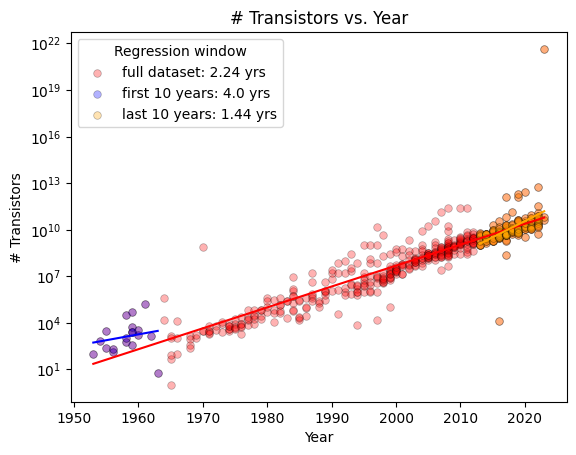

YES! the doubling time has changed across time!!!


In [ ]:
# 5. (for fun). Compute the same regression for the first 10 years of the data and the last 10 years of the data. 
    # Has the doubling time changed over the history of computing?

b0,b1,df_f = comp_LR(df_m,1000,'start','Year','Transistor Count')
Td = np.log10(2) / b1
b0s,b1s,df_s = comp_LR(df_m,10,'start','Year','Transistor Count')
Td_s = np.log10(2) / b1s
b0e,b1e,df_e = comp_LR(df_m,10,'end','Year','Transistor Count')
Td_e = np.log10(2) / b1e

plots = [
    [[df_f, b0,  b1 ], 'red','full dataset'],    # full
    [[df_s, b0s, b1s], 'blue','first 10 years'],   # first 10 years
    [[df_e, b0e, b1e], 'orange','last 10 years']  # last 10 years
]


for plotset in plots:
    (df, b0, b1), color, tframe = plotset

    x = pd.to_numeric(df['Year'], errors='coerce')
    y = pd.to_numeric(df['Transistor Count'], errors='coerce')
    mask = np.isfinite(x) & np.isfinite(y) & (y > 0)

    x = x[mask].to_numpy(dtype=float).reshape(-1, 1)
    y = y[mask].to_numpy(dtype=float)

    y_mod = b0 + (b1 * x)

    order = np.argsort(x[:, 0])
    plt.plot(x[order], 10**y_mod[order], color=color)
    Td = np.log10(2) / b1
    
    plt.scatter(x, y, s=30, c=color,edgecolors='black',linewidths=0.5,
                alpha=0.3,label=f'{tframe}: {round(Td,2)} yrs')

plt.title('# Transistors vs. Year')
plt.ylabel('# Transistors')
plt.xlabel('Year')
plt.yscale('log')
plt.legend(title='Regression window')
plt.show()
print('YES! the doubling time has changed across time!!!')

## Problem 3: Row vs column order data access (25 points)
In this problem, you will explore the performance differences between row-major and column-major data access patterns using NumPy arrays. Perform the following tasks:

1. Create a large 2D NumPy array (e.g., 10,000 x 10,000) filled with random numbers from a distribution of your choosing.
2. Implement two functions to compute the sum of all elements in the array using python loops:
   - One function that accesses the array in row-major order.
   - Another function that accesses the array in column-major order.
3. Measure and compare the execution time of both functions using the `time` module or `timeit` library. Make sure to repeat the measurements multiple times (at least 30) to get an average execution time.
4. Compare the performance results to using built in NumPy functions for summing the array. Explain the differences in performance you observe, using concepts such as cache locality and memory access patterns.

In [ ]:
# 1. Create a large 2D NumPy array (e.g., 10,000 x 10,000) filled with random numbers from a distribution of your choosing.

rng = np.random.default_rng(10)
big_ray = np.round(rng.random((5000, 5000)), 6)
big_ray

array([[0.956002, 0.207682, 0.828445, ..., 0.706978, 0.097672, 0.669664],
       [0.227252, 0.701161, 0.65006 , ..., 0.108436, 0.778164, 0.960269],
       [0.611824, 0.86607 , 0.24563 , ..., 0.905741, 0.602517, 0.281836],
       ...,
       [0.668357, 0.322814, 0.917704, ..., 0.147515, 0.650821, 0.765706],
       [0.01429 , 0.665136, 0.887587, ..., 0.282994, 0.393959, 0.321369],
       [0.744249, 0.690843, 0.856432, ..., 0.970748, 0.027746, 0.927246]],
      shape=(5000, 5000))

In [ ]:
# 2. Implement two functions to compute the sum of all elements in the array using python loops:

# 3. Measure and compare the execution time of both functions using the `time` module or `timeit` library. 
    # Make sure to repeat the measurements multiple times (at least 30) to get an average execution time.

# - One function that accesses the array in row-major order.
iterations = 40

execution_times = {}

execution_times['row_manual'] = []
for itr in range(iterations):
    t_strt = time.time()
    row_calc = []
    for i in range(len(big_ray[:,0])):
        sum = 0
        sub = big_ray[i,:]
        for val in sub:
            sum += val
        row_calc.append(float(sum))
    dt = time.time() - t_strt
    execution_times['row_manual'].append(dt)

# - Another function that accesses the array in column-major order.
execution_times['col_manual'] = []
for itr in range(iterations):
    t_strt = time.time()
    col_calc = []
    for i in range(len(big_ray)):
        sum = 0
        sub = big_ray[:,i]
        for val in sub:
            sum += val
        col_calc.append(float(sum))
    dt = time.time() - t_strt
    execution_times['col_manual'].append(dt)


# 4. Compare the performance results to using built in NumPy functions for summing the array. 
execution_times['row_numpy'] = []
for itr in range(iterations):
    t_strt = time.time()
    row_calc = np.sum(big_ray, axis=1)   # row sums
    dt = time.time() - t_strt
    execution_times['row_numpy'].append(dt)

execution_times['col_numpy'] = []
for itr in range(iterations):
    t_strt = time.time()
    col_calc = np.sum(big_ray, axis=0)   # column sums
    dt = time.time() - t_strt
    execution_times['col_numpy'].append(dt)



In [47]:
for key in execution_times.keys():
    avg_time = np.mean(execution_times[key])
    print(f'{key}: {np.round(avg_time,6)} seconds')


row_manual: 3.771719 seconds
col_manual: 3.729684 seconds
row_numpy: 0.009273 seconds
col_numpy: 0.00832 seconds



Average computation speeds of array summing by method
- row_manual: 3.77 seconds
- col_manual: 3.73 seconds
- row_numpy: 0.0093 seconds
- col_numpy: 0.0083 seconds

Numpy is ~ 400x faster than using Python loops


4. Explain the differences in performance you observe, using concepts such as cache locality and memory access patterns.

    - Loop computation: This is slower because within each iteration, the Python interpreter is used for computation. Within every iteration, a check of type is conducted on each element and retrieval of method for calculation. This reduces the ability to access memory from the CPU cache. THe memory access patterns of computing by column or row directly induces inefficient memory access patterns, reducing the cache locality to less efficient methods of memory retrieval, reducing the memory access. 

    - Numpy: Much faster because the loops are compiled in C code in a fixed-type memory. This allows the CPU to access memory more sequentially and exiciently, reducing the need for slower memory retrieval methods such as from RAM. 

## Problem 4: Scaling and parallel computing (25 points)

In this problem, you will use Dask arrays to compute the element-wise standard score (z-score normalization) of a large random array and measure the scaling behavior across 1-4 CPU cores. The z-score is computed as: z = (x - μ) / σ, where μ is the mean and σ is the standard deviation.

Perform the following tasks:

1. Create a function that generates a large Dask array filled with random numbers and computes the z-score normalized array.
2. **Strong scaling**: Fix the array size (e.g., 20,000 x 20,000) and measure execution time using 1, 2, 3, and 4 cores. Calculate the speedup S(p) = T(1)/T(p) and efficiency E(p) = S(p)/p. Plot execution time vs number of cores.
3. **Weak scaling**: Scale the array size proportionally with the number of cores (maintaining constant work per core). Measure execution time for 1-4 cores and plot the results.
4. Discuss your results: Does your implementation achieve good scaling? What factors limit the speedup?

**Hint**: Configure the number of workers using `dask.config.set(num_workers=n)` and use `.compute()` to trigger computation.

In [3]:
# 1. Create a function that generates a large Dask array filled with random numbers and computes the z-score normalized array.

def calc_znorm(dim, chunk, seed, ncores):
    with dask.config.set(num_workers=ncores):
        rng = da.random.default_rng(seed)
        x = rng.random((dim, dim), chunks=(chunk, chunk)).astype("float32")
        norm_x = (x - x.mean(axis=1, keepdims=True)) / x.std(axis=1, keepdims=True)
        return norm_x.mean().compute()   # forces full work, tiny output


In [ ]:
# 2. **Strong scaling**: Fix the array size (e.g., 20,000 x 20,000) and measure execution time using 1, 2, 3, and 4 cores. 
    # Calculate the speedup S(p) = T(1)/T(p) and efficiency E(p) = S(p)/p. Plot execution time vs number of cores.

# Strong Scaling
cores = np.arange(1,5)
dims = 20000
chunk = 2000
exec_times = {}

for ncore in cores:
    
    t_strt = time.time()
    out = calc_znorm(dims,chunk,10,ncore)
    dt = time.time()-t_strt 
    exec_times[int(ncore)] = dt

T1 = exec_times[1]
Sps_ss = []
Eps_ss = []

for ncore in cores:

    Sp = T1 / exec_times[ncore]
    Ep = float(Sp / ncore)
    Sps_ss.append(Sp)
    Eps_ss.append(Ep)

# 3. **Weak scaling**: Scale the array size proportionally with the number of cores (maintaining constant work per core). 
    # Measure execution time for 1-4 cores and plot the results.

# Weak Scaling
base_dim = 5000
exec_times = {}

for ncore in cores:

    dims = base_dim * ncore
    chunk = int(dims/10)
    
    t_strt = time.time()
    calc_znorm(dims,chunk,10,ncore)
    dt = time.time()-t_strt 
    exec_times[int(ncore)] = dt
T1_ws = exec_times[1]
Sps_ws = []
Eps_ws = []
for ncore in cores:
    Sp = T1_ws / exec_times[ncore]
    Ep = float(Sp / ncore)
    Sps_ws.append(Sp)
    Eps_ws.append(Ep)

(0.0, 1.3)

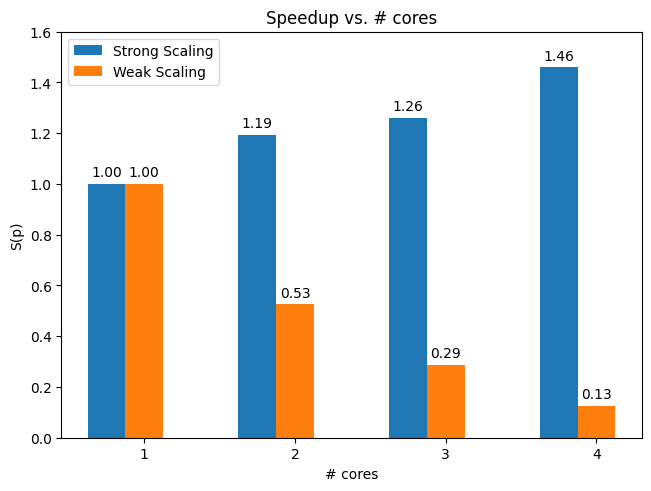

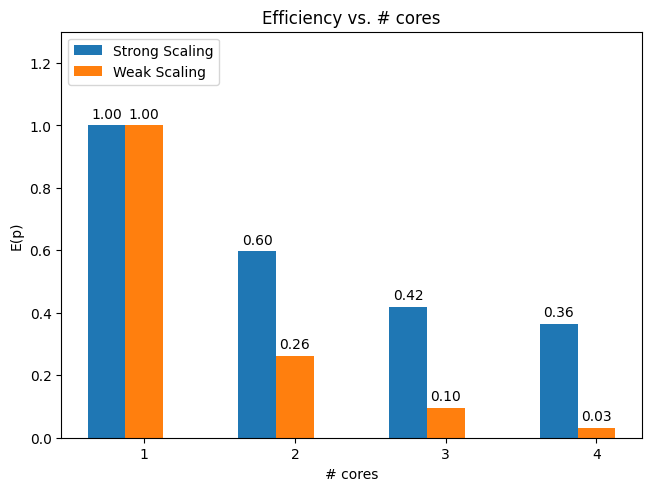

In [7]:
# Speedup Plot
methods = {
    'Strong Scaling': Sps_ss,
    'Weak Scaling': Sps_ws}

x = np.arange(len(cores)) 
width = 0.25  
multiplier = 0

fig, ax = plt.subplots(layout='constrained')

for attribute, measurement in methods.items():
    offset = width * multiplier
    rects = ax.bar(x + offset, measurement, width, label=attribute)
    ax.bar_label(rects, fmt="%.2f",padding=3)
    multiplier += 1

ax.set_xlabel('# cores')
ax.set_ylabel('S(p)')
ax.set_title('Speedup vs. # cores')
ax.set_xticks(x + width, cores)
ax.legend(loc='upper left', ncols=1)
ax.set_ylim(0, round(1.1*max(Sps_ss),2))

# Efficiency Plot
methods = {
    'Strong Scaling': Eps_ss,
    'Weak Scaling': Eps_ws}

x = np.arange(len(cores))  
width = 0.25 
multiplier = 0

fig, ax = plt.subplots(layout='constrained')

for attribute, measurement in methods.items():
    offset = width * multiplier
    rects = ax.bar(x + offset, measurement, width, label=attribute)
    ax.bar_label(rects, fmt="%.2f",padding=3)
    multiplier += 1

ax.set_xlabel('# cores')
ax.set_ylabel('E(p)')
ax.set_title('Efficiency vs. # cores')
ax.set_xticks(x + width, cores)
ax.legend(loc='upper left', ncols=1)
ax.set_ylim(0, 1.3)

4. Discuss your results: Does your implementation achieve good scaling? What factors limit the speedup?

- "Good scaling" is characterized by an increase in Speedup (S(p)) and a constant or gradual decrease in efficiency (E(p)) with the number of cores (p). 
- Speedup: S(p) increased for Strong Scaling, and decreased for Weak Scaling with the number of cores. The weak scaling showed a greater reduction in S(p) compared to the increase S(p) for strong. 
- Efficiency: Both the Strong and Weak Scaling approaches exhibited a reduction in E(p) with core count. However, the weak scaling resulting in a larger reduction of efficiency with increasing core count.

These results imply that the Strong Scaling approach achieved a better scaling than weak. This is because weak scaling increases the total problem size proportionally to the number of cores while keeping an approx constant work per core. Therefore, communication, synchronization, and task scheduling increases with the number of cores. Although the computational workload per core remains constant, these additional tasks required in the weak scaling results in reduced speedup and efficiency. 
